<a href="https://colab.research.google.com/github/dlguswn3659/2020_Image_Lab/blob/master/hair_classification_recent_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install -q tensorflow-io
!pip install -q pydicom

In [ ]:
from PIL import Image
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files
import numpy as np

import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
!pip install -q pydicom

In [ ]:
# Set the random seed number for reproducible results
seedNum = 1

In [ ]:
# Set the TensorFlow version to 2.x in Colab
%tensorflow_version 2.x

In [ ]:
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
from matplotlib import pyplot
from matplotlib.image import imread
from datetime import datetime
from email.message import EmailMessage

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	fig, axs = pyplot.subplots(2, 1, figsize=(12,12))
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='red', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='red', label='test')
	pyplot.show()

In [ ]:
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the mountStorage flag to mount G Drive for storing files (setting True will mount the drive!)
mountStorage = False

Num GPUs Available:  0


In [ ]:
# Set the default optimizer for the remaining portion of the script
default_opt = Adam(learning_rate=0.001)

# **Section 1. Data Preparation**

In [ ]:
# define location of dataset
folder = '/content/gdrive/My Drive/ISIC-melanoma/train/'
folder2 = '/content/gdrive/My Drive/ISIC-melanoma/hair_labeling/'
# plot first few images
hair_label = []
image_field = []

# start_num = 15719
# end_num = 100000

# start_num = 100000
# end_num = 405555

start_num = 405652
end_num = 695029

# start_num = 695059
# end_num = 999642

# start_num = 1000328
# end_num = 1307396

# start_num = 1307419
# end_num = 1601764

# start_num = 1601784
# end_num = 1894741

# start_num = 1894782
# end_num = 2188465

# start_num = 2188566
# end_num = 2491594

file_name = str(start_num) + '_' + str(end_num) + '.csv'

target_row = 1

In [ ]:
######hair이 있는 사진들에 대해서!###########
import csv

hair_image_file = []

ct = 1

with open(folder2 + file_name, newline='') as myfile:
    reader  = csv.reader(myfile, delimiter=',')
    for i in reader:
        if i[1] == '1':
          hair_image_file.append(i[0])
        ct += 1

FileNotFoundError: ignored

In [ ]:
from torchvision import transforms

for i in range (1, 10):#원랜 (1, ct + 1)
  pyplot.subplot(330 + i)
  if os.path.isfile(folder + hair_image_file[i] + '.dcm'):
    filename = folder + hair_image_file[i] + '.dcm'
    dataset = pydicom.dcmread(filename)

    image_bytes = tf.io.read_file(filename)

    image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

    skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

    image_info = np.squeeze(image.numpy())

    rows = int(dataset.Rows) #높이
    cols = int(dataset.Columns) #너비

    cropped = image_info[int(rows/2 - cols/3) :int(rows/2 + cols/3), 0:cols]
    if cols/rows > 1.5:
      cropped = image_info[0 : rows, int(cols/2 - rows*3/4):int(cols/2 + rows*3/4)]
    
    cropped = cv2.resize(cropped, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)             #resize 진행
    
  plt.imshow(cropped)

plt.show()

In [ ]:
hair_image_file = []

ct = 1

with open(folder2 + file_name, newline='') as myfile:
    reader  = csv.reader(myfile, delimiter=',')
    for i in reader:
        if i[1] == '0':
          hair_image_file.append(i[0])
        ct += 1

In [ ]:
from torchvision import transforms

##center crop size ratio
width_ratio = 1
height_ratio = 2/3


for i in range (1, 10):#원랜 (1, ct + 1)
  pyplot.subplot(330 + i)
  if os.path.isfile(folder + hair_image_file[i] + '.dcm'):
    filename = folder + hair_image_file[i] + '.dcm'
    dataset = pydicom.dcmread(filename)

    image_bytes = tf.io.read_file(filename)

    image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

    skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

    image_info = np.squeeze(image.numpy())

    rows = int(dataset.Rows) #높이
    cols = int(dataset.Columns) #너비

    # left = 0 # 여기 작성하다 맘
    # top = int((rows - (cols*height_ratio)) / 2)
    # right = 0
    # bottom = int((rows + (cols*height_ratio)) / 2)

    # image = image_info.crop((left, top, right, bottom))   #center crop 진행
    cropped = image_info[int(rows/2 - cols/3) :int(rows/2 + cols/3), 0:cols]
    if cols/rows > 1.5:
      cropped = image_info[0 : rows, int(cols/2 - rows*3/4):int(cols/2 + rows*3/4)]
    # print(cropped)
    cropped = cv2.resize(cropped, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)             #resize 진행
    
    # print(image_info.shape)
    # print(cropped.shape)
  plt.imshow(cropped)

plt.show()

In [ ]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import scipy.misc
import imageio
from PIL import Image
import numpy as np

# create directories
dataset_home = '/content/gdrive/My Drive/dataset_nonhair_vs_hair/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['nonhair/', 'hair/']		#dog == nonhair, cat == hair
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(seedNum)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
# src_directory = 'train/'
src_directory = '/content/gdrive/My Drive/ISIC-melanoma/train/'

for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	# if file.startswith('hair'):						##요기 if문을 label 0, 1 배열 안에 있는 파일 숫자인지 확인하는걸 만들어서 바꾸면 될 듯. csv에서 해당 파일 레이블이 1인가. 아래코드로!
	with open(folder2 + file_name, newline='') as myfile:
		reader  = csv.reader(myfile, delimiter=',')
		ct = 1
		for i in reader:
			if i[1] == '1':
				file = i[0]
				dst = dataset_home + dst_dir + 'hair/'  + file + '.jpg'
				# copyfile(src, dst)
				dataset = pydicom.dcmread(filename)

				image_bytes = tf.io.read_file(filename)

				image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

				skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

				image_info = np.squeeze(image.numpy())

				rows = int(dataset.Rows) #높이
				cols = int(dataset.Columns) #너비

				cropped = image_info[int(rows/2 - cols/3) :int(rows/2 + cols/3), 0:cols]
				if cols/rows > 1.5:
					cropped = image_info[0 : rows, int(cols/2 - rows*3/4):int(cols/2 + rows*3/4)]
					
				cropped = cv2.resize(cropped, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)
		
				# scipy.misc.toimage(cropped, cmin=0.0, cmax=...).save(dst)
				# imageio.imwrite(dst, cropped[:, :, 0])
				im = Image.fromarray(cropped)
				im.save(dst)
			elif i[1] == '0':
				file = i[0]
				dst = dataset_home + dst_dir + 'hair/'  + file + '.jpg'
				# copyfile(src, dst)
				dataset = pydicom.dcmread(filename)

				image_bytes = tf.io.read_file(filename)

				image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

				skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

				image_info = np.squeeze(image.numpy())

				rows = int(dataset.Rows) #높이
				cols = int(dataset.Columns) #너비

				cropped = image_info[int(rows/2 - cols/3) :int(rows/2 + cols/3), 0:cols]
				if cols/rows > 1.5:
					cropped = image_info[0 : rows, int(cols/2 - rows*3/4):int(cols/2 + rows*3/4)]
					
				cropped = cv2.resize(cropped, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)
		
				# scipy.misc.toimage(cropped, cmin=0.0, cmax=...).save(dst)
				# imageio.imwrite(dst, cropped[:, :, 0])
				im = Image.fromarray(cropped)
				im.save(dst)
		
			print(ct)
			ct = ct + 1
  #         hair_image_file.append(i[0])
		# dst = dataset_home + dst_dir + 'hair/'  + file
		# copyfile(src, dst)
	# elif file.startswith('nonhair'):
	# 	dst = dataset_home + dst_dir + 'nonhair/'  + file
	# 	copyfile(src, dst)

In [ ]:
dataset = pydicom.dcmread(filename)

image_bytes = tf.io.read_file(filename)

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

image_info = np.squeeze(image.numpy())

rows = int(dataset.Rows) #높이
cols = int(dataset.Columns) #너비

cropped = image_info[int(rows/2 - cols/3) :int(rows/2 + cols/3), 0:cols]
if cols/rows > 1.5:
  cropped = image_info[0 : rows, int(cols/2 - rows*3/4):int(cols/2 + rows*3/4)]
  
cropped = cv2.resize(cropped, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)

# **Section 2. Fit and Evaluate Models**

Found 774 images belonging to 2 classes.
Found 226 images belonging to 2 classes.
Epoch 1/20
13/13 [==============================] - 160s 12s/step - loss: 55.3941 - accuracy: 0.5594 - val_loss: 6.2575 - val_accuracy: 0.5398
Epoch 2/20
13/13 [==============================] - 148s 11s/step - loss: 7.5572 - accuracy: 0.6382 - val_loss: 65.0412 - val_accuracy: 0.6637
Epoch 3/20
13/13 [==============================] - 153s 12s/step - loss: 28.9933 - accuracy: 0.6279 - val_loss: 11.8732 - val_accuracy: 0.6991
Epoch 4/20
13/13 [==============================] - 153s 12s/step - loss: 7.5925 - accuracy: 0.7132 - val_loss: 11.3564 - val_accuracy: 0.3496
Epoch 5/20
13/13 [==============================] - 150s 12s/step - loss: 11.9998 - accuracy: 0.6331 - val_loss: 1.6812 - val_accuracy: 0.7124
Epoch 6/20
13/13 [==============================] - 151s 12s/step - loss: 7.6372 - accuracy: 0.6951 - val_loss: 6.9624 - val_accuracy: 0.7345
Epoch 7/20
13/13 [==============================] - 153s 12s

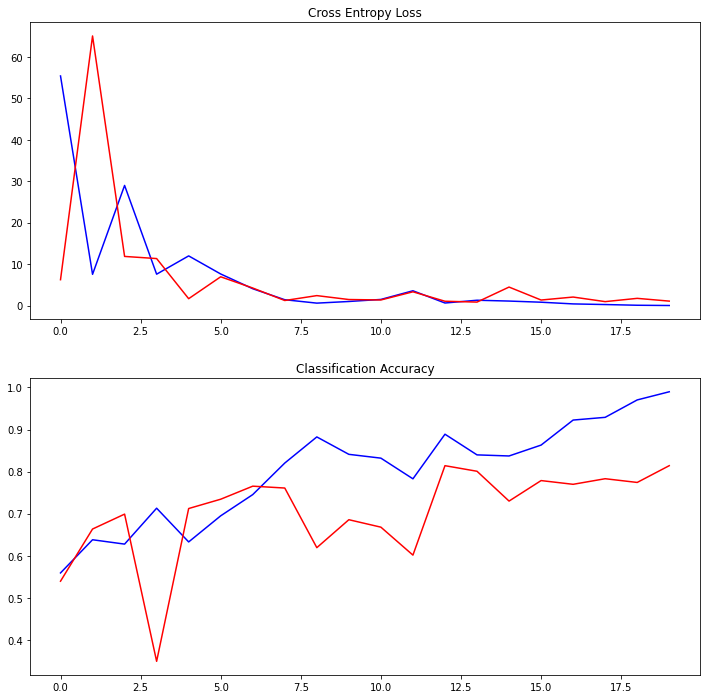

Total time for the model processing: 0:54:39.296135


In [68]:
# baseline model with One Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model1():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(400, 600, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model1 = define_model1()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('/content/gdrive/My Drive/dataset_nonhair_vs_hair/train/',
		class_mode='binary', batch_size=64, target_size=(400, 600))
	test_it = datagen.flow_from_directory('/content/gdrive/My Drive/dataset_nonhair_vs_hair/test/',
		class_mode='binary', batch_size=64, target_size=(400, 600))
	# fit model
	history = model1.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model1.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [ ]:
# baseline model with Two Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model2 = define_model2()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model2.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model2.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [ ]:
# baseline model with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model3():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model3 = define_model3()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model3.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model3.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [ ]:
# baseline model with VGG-3 and dropout (variation #1)
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model4():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model4 = define_model4()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model4.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model4.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))